# 计算物理第三次作业

祝茗 2024202020022

## 傅里叶变换 FT

$$
H(f) = \int_{-\infty}^{\infty} h(t) e^{2\pi i f t} \mathrm{d}t
$$

$$
h(f) = \int_{-\infty}^{\infty} H(t) e^{-2\pi i f t} \mathrm{d}f
$$

$$
2 \pi f =\omega
$$

## 离散傅里叶变化 DFT

$$
h_k = h(t_k), \quad t_k = k \Delta, \quad k = 0, 1, \cdots, N-1
$$

以上傅里叶变换的积分形式可以写成离散的求和形式

$$
H(f_n) \approx \sum_{k=0}^{N-1} h_k e^{2 \pi i f_n t_k} \Delta
$$

其中

$$
f_n = \frac{n}{N \Delta}, \quad n = -\frac{N}{2}, \cdots, \frac{N}{2}
$$

如果记

$$
H_n = \sum_{k=0}^{N-1} h_k e^{2 \pi i f_n t}
$$

则

$$
H(f_n) = H_n \Delta
$$

该常规方法的计算量：$N^2$

## 快速傅里叶变换 FFT

记

$$
W = e^{2 \pi i / N}
$$

则

$$
H_n = \sum_{k=0}^{N-1} W^{nk} h_k
$$

记

$$
H(f_n) = F_n, \quad H(f_k) = F_k
$$

$$
\begin{aligned}
F_k &= \sum_{j=0}^{N-1} e^{2 \pi i j k / N} f_j \\
&= \sum_{j=0}^{N/2-1} e^{2 \pi i k (2j) / N} f_{2j} + \sum_{j=0}^{N/2-1} e^{2 \pi i k (2j+1) / N} f_{2j+1} \\
&= \sum_{j=0}^{N/2-1} e^{2 \pi i k j / (N/2)} f_{2j} + W^k \sum_{j=0}^{N/2-1} e^{2 \pi i k j / (N/2)} f_{2j+1} \\
&= F_{k}^{e} + W^k F_{k}^{o} \\
&= (F_{k}^{ee} + W^k F_{k}^{eo}) + W^k (F_{k}^{oe} + ^k F_{k}^{oo}) \\
&= \cdots
\end{aligned}
$$

计算量：$N \log_{2} N$

### 算法实现

考虑不断二分的逆过程，最后计算的时候是两两按顺序组合起来

通过 01234567 考虑这个过程

01234567

02461357

04261537

最终的顺序

| 初始顺序 | 结束顺序 |
|:-:|:-:|
|000|000|
|001|100|
|010|010|
|011|110|
|100|001|
|101|101|
|110|011|
|111|111|

从结果来看是 **按位取反** (bit reverse)

In [1]:
import numpy as np

def get_Fk(A, ISIGN):
    """递归的傅里叶函数

    Args:
        A: 输入的序列
        ISIGN: 1 表示正变换，-1 表示逆变换

    Returns:
        Fk: 傅里叶变换后的序列
    """
    if len(A) == 1:
        return A
    else:
        # 对偶数和奇数索引的元素递归地调用 get_Fk
        Fk_even = get_Fk(A[::2], ISIGN)  # 获取偶数索引的元素进行递归 FFT
        Fk_odd = get_Fk(A[1::2], ISIGN)  # 获取奇数索引的元素进行递归 FFT

        # 计算旋转因子（称为旋转因子或权重）
        W = np.exp(-ISIGN*1j*np.pi/len(Fk_odd)*np.arange(len(Fk_odd)))

        # 合并偶数部分和奇数部分来构建完整的傅里叶变换结果
        return np.concatenate((Fk_even + W * Fk_odd, Fk_even - W * Fk_odd))


def CFFT(AR, AI, M, ISIGN):
    """连续傅里叶变换

    Args:
        AR: 实部
        AI: 虚部
        M: 2^M 为序列的长度
        ISIGN: 1 表示正变换，-1 表示逆变换

    Returns:
        A: 傅里叶变换后的序列
    """
    A = get_Fk(AR + 1j*AI, ISIGN)

    if ISIGN == -1:
        A /= 2**M  # 逆变换时差了一个常数

    return np.real(A), np.imag(A)

调用 `CFFT` 并与 `numpy.fft.fft` 比较：

/home/mzhu/miniconda3/envs/hoomd4/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/mzhu/miniconda3/envs/hoomd4/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


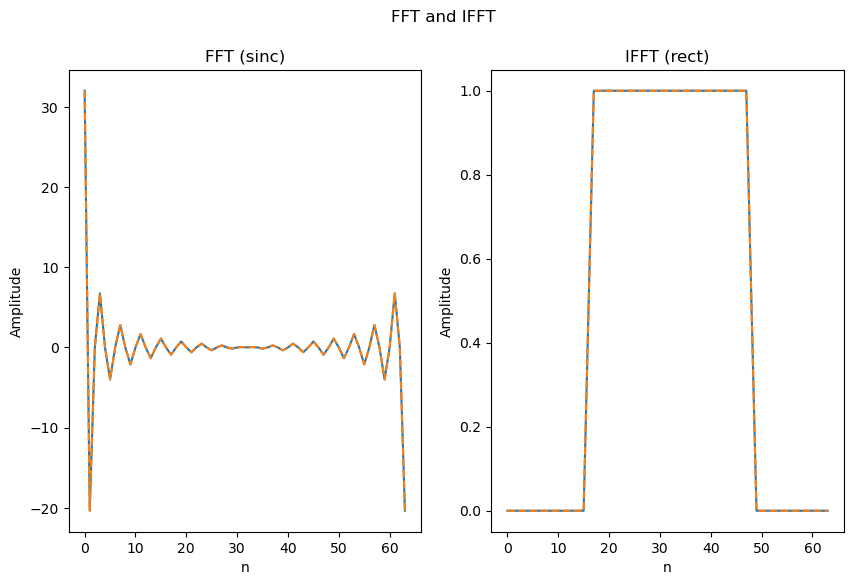

In [2]:
import matplotlib.pyplot as plt

M = 6  # 2^M 为序列的长度
AR = np.zeros(2**M)
AR[2**(M-2):2**M-2**(M-2)] = 1  # 实部是一个 rect 函数
AI = np.zeros(2**M)  # 虚部为 0

FFT_AR, _ = CFFT(AR, AI, M, ISIGN=1)  # 作傅里叶变换，预计得到 sinc 函数
IFFT_FFT_AR, _ = CFFT(FFT_AR, AI, M, ISIGN=-1)  # 作傅里叶逆变换，预计得到原来的 rect 函数

fig, [ax1, ax2] = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10, 6)
)
plt.suptitle('FFT and IFFT')

ax1.set_title('FFT (sinc)')
ax1.set_xlabel('n')
ax1.set_ylabel('Amplitude')
ax1.plot(FFT_AR, label='CFFT')
ax1.plot(np.fft.fft(AR), '--', label='np.fft.fft')

ax2.set_title('IFFT (rect)')
ax2.set_xlabel('n')
ax2.set_ylabel('Amplitude')
ax2.plot(IFFT_FFT_AR, label='CFFT')
ax2.plot(np.fft.ifft(FFT_AR), '--', label='np.fft.ifft')

plt.show()

可以看出, `rect` 函数变换成了 `sinc` 函数，又经逆变换返回了原来的 `rect` 函数, 黄色虚线是作为对照的 `numpy.fft()` 的结果。

贝塞尔函数可以通过积分来计算：

$$
J_z(n) = \frac{i^{-n}}{2\pi} \int_{0}^{2\pi} e^{i z \cos\theta} e^{i n \theta} \mathrm{d}\theta
$$

贝塞尔函数的积分形式可以用 FFT 写成

$$
\begin{aligned}
J_n(z) &= \frac{i^{-n}}{2\pi} \sum_{j=0}^{N-1} e^{i z \cos\left(\frac{2\pi j}{N}\right)} e^{i n \frac{2\pi j}{N}} \frac{2\pi}{N} \\
&= \frac{i^{-n}}{N} \sum_{j=0}^{N-1} e^{i z \cos\left(\frac{2\pi j}{N}\right)} e^{\frac{2\pi i n j}{N}}
\end{aligned}
$$

In [10]:
for z in [1, 10, 100]:
    M = 10
    N = 2**M
    AR = np.cos(z*np.cos(2*np.pi*np.arange(N)/N))  # 实部
    AI = np.sin(z*np.cos(2*np.pi*np.arange(N)/N))  # 虚部

    FFT_AR, FFT_AI = CFFT(AR, AI, M=M, ISIGN=1)  # 作傅里叶变换
    Jn = FFT_AR * 1j**np.arange(N)/N + FFT_AI * 1j**np.arange(-1, N-1, 1)/N  # 乘上系数

    print(Jn[:34].real)  # 输出前 10 项

[ 7.65197687e-01  4.40050586e-01  1.14903485e-01  1.95633540e-02
  2.47663896e-03  2.49757730e-04  2.09383380e-05  1.50232582e-06
  9.42234417e-08  5.24925018e-09  2.63061506e-10  1.19800699e-11
  4.99969949e-13  1.92537968e-14  6.82773250e-16  7.79461744e-17
  2.41343415e-18  2.57712177e-18  2.84961715e-18  5.13684372e-18
 -4.64738480e-19 -5.52469586e-19 -1.79826983e-18  1.30737513e-18
  2.63571987e-18  9.73983958e-19 -1.10298945e-18  2.02503472e-18
  3.82357166e-20 -2.72197902e-18 -1.25172191e-17  4.05828808e-17
  2.34545769e-18  1.32972767e-18]
[-2.45935764e-01  4.34727462e-02  2.54630314e-01  5.83793793e-02
 -2.19602686e-01 -2.34061528e-01 -1.44588421e-02  2.16710918e-01
  3.17854127e-01  2.91855685e-01  2.07486107e-01  1.23116528e-01
  6.33702550e-02  2.89720839e-02  1.19571632e-02  4.50797314e-03
  1.56675619e-03  5.05646670e-04  1.52442485e-04  4.31462775e-05
  1.15133692e-05  2.90719947e-06  6.96868512e-07  1.59021987e-07
  3.46326297e-08  7.21463500e-09  1.44054530e-09  2.7620

结果与第一次作业的 `bessel_x1.dat` `bessel_x10.dat` 的结果基本保持一致。